<a href="https://colab.research.google.com/github/xhxuciedu/CS284A/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS184A/284A: AI in Biology and Medicine
# HW3 


# Predicting TF Binding Sites

Transcription Factors (TFs) are proteins that bind to the DNA and help regulate gene transcription. The TFs have to recognize some "motif" on the DNA upstream from the gene, and DNA accessibility also plays a role.  

In tis problem set, we will develop ML methods to predict which sequences can be bound by a transcription factor called JUND.  The binding profile of JUND expressed in terms of a sequence logo is shown in the following picture.

More information on JUND can be found here:
- https://www.genecards.org/cgi-bin/carddisp.pl?gene=JUND

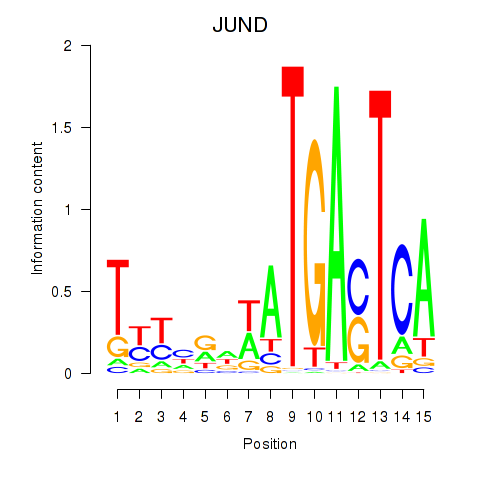

In [ ]:
# get the image
from IPython import display
display.Image("https://www.ismara.unibas.ch/ISMARA/scratch/NHBE_SC2/ismara_report/logos/JUND.png", width=350)


## MLP model 

In this assignment you'll write an MLP model the predict whether a segments of the human chromosome 22 (Chr22) contain the binding sites for the JUND TF. You can modify the mlp notebook I shared with you to work on this problem. You need to have at least one hidden layer. You have to compute a weighted loss, and include accessibility information in your model, as described below.



## Dataset
The data comprises 101 length segments from Chr22, with each position a one-hot vector denoting one of the four bases (A, C, G, T). Thus, each element of the input is 2d with size 101×4. Each such element has a target label 0 or 1, indicating whether the TF binds to that segment or not. The data also includes a weight per input element, since there are only a few binding sites (0.42%), so that you'd obtain an accuracy of 99.58% just by predicting there are no binding sites. This means you have to use the weights to discount the losses for label 0 and enhance the losses for label 1 items. Finally, there is an array of values, one per input element, that also indicates the chromosome accessibility for that segment.


Data Credit: Mohammed Zaki

## Download data



*   First, you need to download data file named "TF_data.zip" from Canvas. Unzip it and create the train, valid, test directories.

*   If you use Google Colab, you can first upload the TF_data.zip file, and then run the follow command

<center><code>!unzip TF_data.zip</code></center>

*   The data is split into training, validation and testing sets. Each set contains the following files:
  * shard-0-X.joblib: the set of 101 x 4 input elements
  * shard-0-y.joblib: the true labels: 0 or 1
  * shard-0-w.joblib: weight per input element
  * shard-0-a.joblib: accessibility value per input element

*   After unzip the data file, you  can read these files by using joblib.load function, which will populate a numpy array. For example
<center><code>X = joblib.load('shard-0-X.joblib')</code></center>
will results in a numpy array X, which you can then convert to torch tensor, and so on.

*  The roles of training, validation and testing sets:
  * Use training set to tune the parameters of the model. 
  * Use validation set to select model structure and hyperparamters (e.g., number of epochs, learning rate, etc). 
  * Use test set for the final evaluation.  You should never touch test set for either your model training or model selection. 

In [ ]:
# Uncomment the following command if you run this code in Google Colab
#!unzip TF_data.zip

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

## Set up DataLoader for fetching training and testing data

Because we use mini-batch gradient descent for training.  We need to set up dataloader that can provide us a minibatch of data samples. 



In [ ]:
from torch._C import dtype
from torch.utils.data import Dataset

class JUND_Dataset(Dataset):
    def __init__(self, data_dir):
        '''load X, y, w, a from data_dir'''        
        super(JUND_Dataset, self).__init__()

        # load X, y, w, a from given data_dir
        # convert them into torch tensors
        self.X = torch.from_numpy(joblib.load(data_dir + '/shard-0-X.joblib')).float()
        self.y = torch.from_numpy(joblib.load(data_dir + '/shard-0-y.joblib')).float()
        self.w = torch.from_numpy(joblib.load(data_dir + '/shard-0-w.joblib')).float()
        self.a = torch.from_numpy(joblib.load(data_dir + '/shard-0-a.joblib')).float()

    def __len__(self):
        '''return len of dataset'''
        return self.X.shape[0]

    def __getitem__(self, idx):
        '''return X, y, w, and a values at index idx'''
        return self.X[idx],self.y[idx],self.w[idx], self.a[idx]

In [ ]:
# get data
# 
# You may need to change the directory if the data are not stored under current directory
# 
train_dataset = JUND_Dataset('train_dataset')
test_dataset = JUND_Dataset('test_dataset')

### Traing and test data

In [ ]:
batch_size = 100   

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))

Your result should look like:

```
Train data:  276216
Test data:  34528
```



### Fetch a minibatch and check the size of the data

In [ ]:
X,y,w,a = next(iter(train_loader))

In [ ]:
# run the following code to check the size of data in each minibatch
X.shape, y.shape, w.shape, a.shape

Your result should look like the following:

```
(torch.Size([100, 101, 4]),
 torch.Size([100, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))
```



# Problem 1

Define an MLP (multi-layer perceptron) with at least one hidden layer to predict the labels given inputs. 

Please note the following:

- The label for each input is either 0 or 1, so this is essentially a binary classification problem. 
- Input consist of both X and a:
  - X: represents the DNA sequence. Each position is a one-hot vector denoting one of the four bases (A, C, G, T). Thus, each element of the input is 2d with size 101×4.   Since each input is treated as a vector in MLP, the 2d array needs to be flattened into a 404-dimensional vector. 
  - a: represents the chromatin accessiblity of the input DNA sequence segment. You can think of "a" as an additional feature for each input. You can decide how to use it.  For instance, if you are using hidden dimension of 128, then after concatenating the accessibility value, it will become a 129d vector, which should be fed to the final output layer of size 1, since we have a binary class/label.

An initial template code, representing a simple model, is provided.  Your job is to change the definition of the model to improve the model's performance on the test dataset. 


In [ ]:
###############################################################################
#  modify this code block
###############################################################################
# MLP
class MyModel(nn.Module):
    def __init__(self, input_size=101*4, hidden_size=128):
        super(MyModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU())
        self.fc = nn.Linear(hidden_size+1, 1)
        
    def forward(self, X, a):
        out = X.reshape(X.size(0),-1)
        out = self.layer1(out)
        out = torch.cat((out, a),1)
        out = self.fc(out)
        return out
# end of model definition
###############################################################################

### Have a test run of your model

In [ ]:
model = MyModel()
output = model(X,a)

Your model should run smoothly.  The size of output should be 100 - the same as the minibatch size. 

# Training 

Next you need to define a loss function and then run gradient descend to learn the weights of the neural net. 

- There is a strong class imbalance problem in the training set (many more 0's than 1's). 

- To handle the class imbalance problem, we treat each sample differently.  Each data point is assigned a weight. Take a look at the variable named "w" in each data set.  

- Define a loss function, in which the total loss is a weighted combination of losses coming from each sample.  Use the weights specified in "w".   Note that this definition is different from our typical loss, where each sample contributes equally to the final total loss.

- You should use binary_cross_entropy_with_logits with weight set to the weights per input element. Check out the documentation for details.

In [ ]:
###############################################################
# complete this code block
# define loss and optimizer
###############################################################
criterion = 
###############################################################

In [ ]:
# have a test run to check of your loss is defined properly
loss = criterion(output, y)


## You task:

You need to train the model on the training data, and use the **validation data** to select how many epochs you want to use and to choose the hidden dimension. 

Use the **weighted prediction accuracy** as the evaluation metric. That is, sum of the weights of the correct predictions divided by the total weight across all the input elements. 

Finally, report the **weighted accuracy on the test data.**

### Run Training

In [ ]:
# Choose hyper parameters and optimizer 
num_epochs = 5
learning_rate = 0.001
optimizer = 

In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (X, y, w, a) in enumerate(train_loader):
        # images = images.to(device)
        # labels = labels.to(device)
        
        # Forward pass
        output = model(X, a)
        criterion.weight = w
        loss = criterion(output, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


## Final Evaluation

### Generate predictions on test set

In [ ]:
import itertools

y_pred_list = []
y_target_list = []
model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
     for i, (X, y, w, a) in enumerate(test_loader):
        output = model(X, a)
        y_pred_tag = (output>0).int()
        y_pred_list.append(y_pred_tag.detach().numpy())
        y_target_list.append(y.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))


#Takes arrays and makes them list of list for each batch        
y_target_list = [a.squeeze().tolist() for a in y_target_list]
#flattens the lists in sequence
ytest_target = list(itertools.chain.from_iterable(y_target_list))

### Report
- Precision
- Recall
- F1 Score
- Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(ytest_target ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(ytest_target,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(ytest_target,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(ytest_target,ytest_pred)))

Confusion Matrix of the Test Set
-----------
[[30919  3463]
 [  127    19]]
Precision of the MLP :	0.005456634118322803
Recall of the MLP    :	0.13013698630136986
F1 Score of the Model :	0.010474090407938258


##  Write code to **weighted prediction accuracy** 

That is, sum of the weights of the correct predictions divided by the total weight across all the input elements.

Report the weighted accuracy on the test data.



In [5]:
###########################################################
#
#  Complete the following function which calculates weight prediction accuracy
#
def weight_accuracy(predicted_y, true_y, weight):
  '''
    Inputs:  
         predicted_y:  predicted labels 
         true_y:  true labels
         weight:  weight of each sample
    return:  
        sum of the weights of the correct predictions divided by the total weight across all the input elements
  '''


###########################################################

# Problem 2

- Define a CNN model to solve the above problem. 
- The CNN model receives the same inputs. Instead of using MLP, it uses convolution to extract features.  
- Different from 2d images, the convolution will be 1d convolution
- Again, use validation set to design your model and select hyperparamters. 
- Report weight accuracy on test set
- Comment on your observations. 

In [ ]:
# Convolutional neural network 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        
    def forward(self, X, abs):
        return out